In [30]:
import torch
import neuralprocesses.torch as nps
from neuralprocesses.data.predprey import PredPreyRealGenerator, PredPreyGenerator
import matplotlib.pyplot as plt

In [157]:
def add_indicators_and_concat(x_list, indicator_values=None):
    if indicator_values is None:
        indicator_values = torch.tensor([0, 1])
    x_list = [torch.cat([x, torch.full(x.shape, indicator_values[idx])], dim=1) for idx, x in enumerate(x_list)]
    return torch.cat(x_list, dim=-1)

def pre_process_predprey_batch(batch):
    x_contexts = {
        'pred': batch['contexts'][0][0],
        'prey': batch['contexts'][1][0]
    }
    y_contexts = {
        'pred': batch['contexts'][0][1],
        'prey': batch['contexts'][1][1]
    }
    x_target = {
        'pred': batch['xt'][0][0],
        'prey': batch['xt'][1][0]
    }
    pred_ind, prey_ind = 0, 1
    x_context = add_indicators_and_concat(
        [torch.tensor(x_contexts[animal]) for animal in ['pred', 'prey']],
        indicator_values=torch.tensor([pred_ind, prey_ind])
    )
    x_target = add_indicators_and_concat(
        [torch.tensor(x_target[animal]) for animal in ['pred', 'prey']],
        indicator_values=torch.tensor([pred_ind, prey_ind])
    )
    y_context = torch.cat([torch.tensor(y_contexts['pred']), torch.tensor(y_contexts['prey'])], dim=-1)
    y_target = torch.cat([torch.tensor(batch['yt'][0]), torch.tensor(batch['yt'][1])], dim=-1)

    return x_context, y_context, x_target, y_target

In [160]:
# Construct a AGNP.
convcnp = nps.construct_agnp(dim_x=2, dim_y=1, likelihood="het")

# Construct optimiser.
opt = torch.optim.Adam(convcnp.parameters(), 1e-3)

data_generator = PredPreyGenerator(
    float, 
    mode="forecasting",
    batch_size=4
)

for i in range(5):
    # Sample a batch of new context and target sets. Replace this with your data. The
    # shapes are `(batch_size, dimensionality, num_data)`.
    print(f"batch {i}")
    x_context, y_context, x_target, y_target = pre_process_predprey_batch(data_generator.generate_batch())
    # Compute the loss and update the model parameters.
    loss = -torch.mean(
        nps.loglik(
            convcnp, 
            x_context.float(), 
            y_context.float(), 
            x_target.float(), 
            y_target.float(), 
            normalise=True
        )
    )

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()


new_batch = data_generator.generate_batch()
x_context, y_context, x_target, y_target = pre_process_predprey_batch(new_batch)
mean, var, noiseless_samples, noisy_samples = nps.predict(
    convcnp, 
    x_context.float(), 
    y_context.float(), 
    x_target.float(), 
    num_samples=100
)
    

batch 0
batch 1
batch 2
batch 3
batch 4


In [161]:
x_context

tensor([[[57.3746, 55.3063,  7.2514,  ..., 63.2618, 14.6780,  8.5279],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000]],

        [[57.3746, 55.3063,  7.2514,  ..., 63.2618, 14.6780,  8.5279],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000]],

        [[57.3746, 55.3063,  7.2514,  ..., 63.2618, 14.6780,  8.5279],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000]],

        [[57.3746, 55.3063,  7.2514,  ..., 63.2618, 14.6780,  8.5279],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000]]],
       dtype=torch.float64)

In [3]:
# Construct a AGNP.
convcnp = nps.construct_agnp(dim_x=2, dim_y=2, likelihood="het")

# Construct optimiser.
opt = torch.optim.Adam(convcnp.parameters(), 1e-3)

# Training: optimise the model for 32 batches.
for _ in range(32):
    # Sample a batch of new context and target sets. Replace this with your data. The
    # shapes are `(batch_size, dimensionality, num_data)`.
    x, y = batch['contexts'][idx]
    xt = batch['xt'][idx][0]
    yt = batch['yt'][idx]
    xc = torch.randn(16, 1, 10)  # Context inputs
    yc = torch.randn(16, , 10)  # Context outputs
    xt = torch.randn(16, 1, 15)  # Target inputs
    yt = torch.randn(16, 2, 15)  # Target output

    # Compute the loss and update the model parameters.
    loss = -torch.mean(nps.loglik(convcnp, xc, yc, xt, yt, normalise=True))
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

# Testing: make some predictions.
mean, var, noiseless_samples, noisy_samples = nps.predict(
    convcnp,
    torch.randn(16, 1, 10),  # Context inputs
    torch.randn(16, 2, 10),  # Context outputs
    torch.randn(16, 1, 15),  # Target inputs
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (160x3 and 2x256)

In [53]:
data_generator = PredPreyGenerator(
    float, 
    mode="forecasting",
    batch_size=16
)

In [133]:
batch =  data_generator.generate_batch()

In [147]:
batch['xt'][0][0].shape

(4, 1, 163)

In [47]:
batch =  data_generator.generate_batch()

(16, 1, 87) (16, 1, 87)
(16, 1, 83) (16, 1, 83)


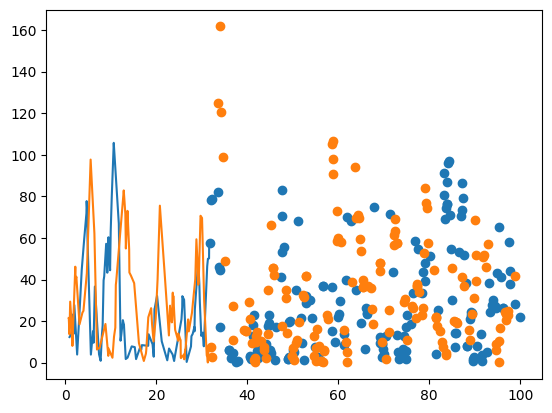

In [90]:
b_idx = 2
for idx, animal in zip([0,1],['pred','prey']):
    x, y = batch['contexts'][idx]
    print(x.shape, y.shape)
    xt = batch['xt'][idx][0]
    yt = batch['yt'][idx]

    ord = torch.argsort(torch.tensor(x[b_idx,0,:]))
    t_ord = torch.argsort(torch.tensor(xt[b_idx,0,:]))
    plt.plot(x[b_idx,0][ord], y[b_idx,0][ord], label=animal)
    plt.scatter(xt[b_idx,0][t_ord], yt[b_idx, 0][t_ord], label=f"{animal} target")


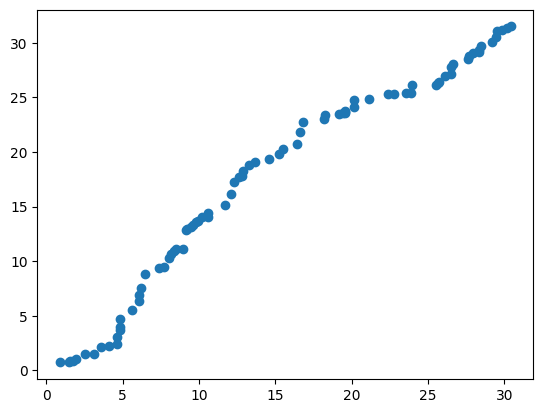

In [112]:
x_contexts = {
    'pred': batch['contexts'][0][0][:,0,:],
    'prey': batch['contexts'][1][0][:,0,:]
}
y_contexts = {
    'pred': batch['contexts'][0][1][:,0,:],
    'prey': batch['contexts'][1][1][:,0,:]
}
xords = {
    'pred': torch.argsort(torch.tensor(x_contexts['pred']), dim=-1),
    'prey': torch.argsort(torch.tensor(x_contexts['prey']), dim=-1)
}
plt.scatter(
    x_contexts['pred'][0, xords['pred'][0,:83]],
    x_contexts['prey'][0, xords['prey'][0,:83]],
)

In [126]:
batch['contexts'][0][1].shape

(16, 1, 87)

In [110]:
xords['pred'].shape

torch.Size([16, 87])